1. Imports

In [1]:
!pip install -q datasets

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models

from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report

import numpy as np
import random

2. Seed

In [2]:
# Reprodüksiyon için seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


3. Device Setting

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


4. Loading HuggingFace Dataset & train/val/test

In [4]:
# PlantVillage dataset (BrandonFors version)
dataset = load_dataset("BrandonFors/Plant-Diseases-PlantVillage-Dataset")

train_ds = dataset["train"]
test_ds  = dataset["test"]

print(train_ds)
print(test_ds)

# splitting validation (%15)
split = train_ds.train_test_split(
    test_size=0.15,
    stratify_by_column="label",   # split according to classes
    seed=SEED
)

train_ds = split["train"]
val_ds   = split["test"]

print("Train len:", len(train_ds))
print("Val len  :", len(val_ds))
print("Test len :", len(test_ds))

# labels
label_feature = train_ds.features["label"]
id2label = label_feature.names               # index -> class name
label2id = {name: i for i, name in enumerate(id2label)}
num_classes = len(id2label)

print("Num classes:", num_classes)
print("Örnek sınıflar:", id2label[:10])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/321M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/362M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43456 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10849 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 43456
})
Dataset({
    features: ['image', 'label'],
    num_rows: 10849
})
Train len: 36937
Val len  : 6519
Test len : 10849
Num classes: 38
Örnek sınıflar: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


5. Label Türkçeleştirme, Vocabulary, Caption Dataset

In [5]:
# İngilizce sınıf adlarını arayüzde Türkçe göstermek için map
label_tr_map = {
    "Apple___Apple_scab": "Elma – Elma kara leke (Apple scab)",
    "Apple___Black_rot": "Elma – Siyah çürüklük",
    "Apple___Cedar_apple_rust": "Elma – Ardıç–elma pası",
    "Apple___healthy": "Elma – Sağlıklı",

    "Blueberry___healthy": "Yaban mersini – Sağlıklı",

    "Cherry_(including_sour)___Powdery_mildew": "Kiraz – Külleme",
    "Cherry_(including_sour)___healthy": "Kiraz – Sağlıklı",

    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": "Mısır – Cercospora / gri yaprak lekesi",
    "Corn_(maize)___Common_rust_": "Mısır – Yaygın pas",
    "Corn_(maize)___Northern_Leaf_Blight": "Mısır – Kuzey yaprak yanıklığı",
    "Corn_(maize)___healthy": "Mısır – Sağlıklı",

    "Grape___Black_rot": "Üzüm – Siyah çürüklük",
    "Grape___Esca_(Black_Measles)": "Üzüm – Esca (siyah kızamık)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)": "Üzüm – Yaprak yanıklığı (Isariopsis lekesi)",
    "Grape___healthy": "Üzüm – Sağlıklı",

    "Orange___Haunglongbing_(Citrus_greening)": "Portakal – Huanglongbing (citrus greening)",

    "Peach___Bacterial_spot": "Şeftali – Bakteriyel leke",
    "Peach___healthy": "Şeftali – Sağlıklı",

    "Pepper,_bell___Bacterial_spot": "Dolmalık biber – Bakteriyel leke",
    "Pepper,_bell___healthy": "Dolmalık biber – Sağlıklı",

    "Potato___Early_blight": "Patates – Erken yanıklık",
    "Potato___Late_blight": "Patates – Geç yanıklık",
    "Potato___healthy": "Patates – Sağlıklı",

    "Raspberry___healthy": "Ahududu – Sağlıklı",

    "Soybean___healthy": "Soya fasulyesi – Sağlıklı",

    "Squash___Powdery_mildew": "Kabak – Külleme",

    "Strawberry___Leaf_scorch": "Çilek – Yaprak yanıklığı (leaf scorch)",
    "Strawberry___healthy": "Çilek – Sağlıklı",

    "Tomato___Bacterial_spot": "Domates – Bakteriyel leke",
    "Tomato___Early_blight": "Domates – Erken yanıklık",
    "Tomato___Late_blight": "Domates – Geç yanıklık",
    "Tomato___Leaf_Mold": "Domates – Yaprak küfü",
    "Tomato___Septoria_leaf_spot": "Domates – Septoria yaprak lekesi",
    "Tomato___Spider_mites Two-spotted_spider_mite": "Domates – İki noktalı kırmızı örümcek (akar)",
    "Tomato___Target_Spot": "Domates – Hedef leke (target spot)",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "Domates – Yellow Leaf Curl virüsü",
    "Tomato___Tomato_mosaic_virus": "Domates – Domates mozaik virüsü",
    "Tomato___healthy": "Domates – Sağlıklı",
}

def get_tr_label_from_id(label_id: int) -> str:
    en_name = id2label[label_id]
    return label_tr_map.get(en_name, en_name)


In [6]:
def label_to_turkish_template(label_name: str) -> str:
    """
    Ör: 'Tomato___Late_blight' ->
        'Domates yaprağında late blight hastalığının tipik belirtileri görülmektedir.'
    """
    parts = label_name.split("___")
    if len(parts) == 2:
        plant, disease = parts
    else:
        plant, disease = parts[0], "disease"

    plant_tr = plant.replace("_", " ")
    disease_tr = disease.replace("_", " ").lower()

    if "healthy" in disease.lower():
        return f"{plant_tr} yaprağında hastalık belirtisi görülmemektedir; yaprak sağlıklı görünmektedir."
    else:
        return f"{plant_tr} yaprağında {disease_tr} hastalığının tipik belirtileri görülmektedir."

# control
for i in range(5):
    print(id2label[i], "->", label_to_turkish_template(id2label[i]))


Apple___Apple_scab -> Apple yaprağında apple scab hastalığının tipik belirtileri görülmektedir.
Apple___Black_rot -> Apple yaprağında black rot hastalığının tipik belirtileri görülmektedir.
Apple___Cedar_apple_rust -> Apple yaprağında cedar apple rust hastalığının tipik belirtileri görülmektedir.
Apple___healthy -> Apple yaprağında hastalık belirtisi görülmemektedir; yaprak sağlıklı görünmektedir.
Blueberry___healthy -> Blueberry yaprağında hastalık belirtisi görülmemektedir; yaprak sağlıklı görünmektedir.


In [7]:
from collections import Counter

def build_vocab_from_labels(id2label, min_freq=1):
    texts = [label_to_turkish_template(lbl).lower() for lbl in id2label]

    counter = Counter()
    for t in texts:
        counter.update(t.split())

    stoi = {
        "<pad>": 0,
        "<bos>": 1,
        "<eos>": 2,
        "<unk>": 3,
    }

    for word, freq in counter.items():
        if freq >= min_freq and word not in stoi:
            stoi[word] = len(stoi)

    itos = {i: w for w, i in stoi.items()}
    return stoi, itos

stoi, itos = build_vocab_from_labels(id2label)
vocab_size = len(stoi)
pad_idx = stoi["<pad>"]
bos_idx = stoi["<bos>"]
eos_idx = stoi["<eos>"]

print("Vocab size:", vocab_size)
list(stoi.items())[:15]

Vocab size: 70


[('<pad>', 0),
 ('<bos>', 1),
 ('<eos>', 2),
 ('<unk>', 3),
 ('apple', 4),
 ('yaprağında', 5),
 ('scab', 6),
 ('hastalığının', 7),
 ('tipik', 8),
 ('belirtileri', 9),
 ('görülmektedir.', 10),
 ('black', 11),
 ('rot', 12),
 ('cedar', 13),
 ('rust', 14)]

In [8]:
def decode_ids(token_ids, itos, bos_idx=1, eos_idx=2, pad_idx=0):
    """
    Tek bir cümlenin token id dizisini alır, <bos>/<eos>/<pad> hariç
    kelimeleri string olarak geri döndürür.
    """
    words = []
    for tid in token_ids:
        tid = int(tid)
        if tid in [bos_idx, pad_idx]:
            continue
        if tid == eos_idx:
            break
        words.append(itos.get(tid, "<unk>"))
    return " ".join(words)


6. PyTorch Dataset Wrapper & Transforms

In [9]:
IMG_SIZE = 224

train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    ),
])

val_test_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

class HFImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"]
        label = item["label"]

        img = img.convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, label

7. DataLoaders

In [10]:
BATCH_SIZE = 32
NUM_WORKERS = 2

train_dataset = HFImageDataset(train_ds, transform=train_transform)
val_dataset   = HFImageDataset(val_ds,   transform=val_test_transform)
test_dataset  = HFImageDataset(test_ds,  transform=val_test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [11]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader

IMG_SIZE = 224

caption_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

def encode_text(text: str, stoi, max_len=30):
    tokens = text.lower().split()
    ids = [stoi.get(tok, stoi["<unk>"]) for tok in tokens]

    ids = [stoi["<bos>"]] + ids + [stoi["<eos>"]]

    if len(ids) < max_len:
        ids = ids + [stoi["<pad>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
        ids[-1] = stoi["<eos>"]

    return torch.tensor(ids, dtype=torch.long)

class CaptionDataset(Dataset):
    def __init__(self, hf_dataset, transform, id2label, stoi, max_len=30):
        self.ds = hf_dataset
        self.transform = transform
        self.id2label = id2label
        self.stoi = stoi
        self.max_len = max_len

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        img = item["image"].convert("RGB")
        img = self.transform(img)

        label_id = item["label"]
        label_name = self.id2label[label_id]

        text = label_to_turkish_template(label_name)
        text_ids = encode_text(text, self.stoi, self.max_len)

        return img, text_ids

In [12]:
# dataloaders for caption
caption_train_dataset = CaptionDataset(train_ds, caption_transform, id2label, stoi, max_len=30)
caption_val_dataset   = CaptionDataset(val_ds,   caption_transform, id2label, stoi, max_len=30)

caption_train_loader = DataLoader(caption_train_dataset, batch_size=32, shuffle=True,  num_workers=2)
caption_val_loader   = DataLoader(caption_val_dataset,   batch_size=32, shuffle=False, num_workers=2)

imgs, txts = next(iter(caption_train_loader))
print("Image batch:", imgs.shape)
print("Text batch:", txts.shape)

Image batch: torch.Size([32, 3, 224, 224])
Text batch: torch.Size([32, 30])


8. Model (ResNet18 + Transfer Learning)

In [13]:
# pretrained ResNet18 trained on ImageNet
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

for param in resnet.parameters():
    param.requires_grad = False

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

model = resnet.to(device)
print(model.fc)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


Linear(in_features=512, out_features=38, bias=True)


9. Loss, Optimizer, Functions

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss, epoch_acc, macro_f1

10. Train Loop

In [15]:
EPOCHS = 5

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc, val_f1 = evaluate(
        model, val_loader, criterion, device
    )

    print(f"Epoch {epoch}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}% | Val Macro-F1: {val_f1:.4f}")

    # save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_resnet18_plantvillage.pt")
        print("  -> Best model saved.")

Epoch 1/5
  Train Loss: 2.0899 | Train Acc: 52.38%
  Val   Loss: 1.2266 | Val Acc: 76.81% | Val Macro-F1: 0.6225
  -> Best model saved.
Epoch 2/5
  Train Loss: 0.9936 | Train Acc: 82.28%
  Val   Loss: 0.7266 | Val Acc: 86.36% | Val Macro-F1: 0.7825
  -> Best model saved.
Epoch 3/5
  Train Loss: 0.6695 | Train Acc: 87.39%
  Val   Loss: 0.5250 | Val Acc: 89.42% | Val Macro-F1: 0.8469
  -> Best model saved.
Epoch 4/5
  Train Loss: 0.5199 | Train Acc: 89.58%
  Val   Loss: 0.4222 | Val Acc: 90.72% | Val Macro-F1: 0.8663
  -> Best model saved.
Epoch 5/5
  Train Loss: 0.4388 | Train Acc: 90.54%
  Val   Loss: 0.3543 | Val Acc: 92.01% | Val Macro-F1: 0.8925
  -> Best model saved.


11. Last Evaluation on Test Set

In [16]:
# load the best model
model.load_state_dict(torch.load("best_resnet18_plantvillage.pt", map_location=device))

test_loss, test_acc, test_f1 = evaluate(model, test_loader, criterion, device)
print("=== TEST SONUÇLARI ===")
print(f"Test Loss    : {test_loss:.4f}")
print(f"Test Acc     : {test_acc*100:.2f}%")
print(f"Test Macro-F1: {test_f1:.4f}")

=== TEST SONUÇLARI ===
Test Loss    : 0.3628
Test Acc     : 91.37%
Test Macro-F1: 0.8767


In [17]:
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Sınıflandırma modelini yeniden kur (num_classes aynı olmalı)
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

# Eğittiğin ağırlıkları yükle
resnet.load_state_dict(torch.load("best_resnet18_plantvillage.pt", map_location=device))

# Encoder: son fc katmanına kadar
encoder = nn.Sequential(*list(resnet.children())[:-1])  # [B, 512, 1, 1]
encoder = encoder.to(device)
encoder.eval()  # şimdilik dondurduk

feature_dim = in_features  # 512


Device: cuda


12. Caption Modeli

In [18]:
class ImageCaptionModel(nn.Module):
    def __init__(self, encoder, feature_dim, vocab_size, emb_dim=256, hidden_dim=512, num_layers=1, pad_idx=0):
        super().__init__()
        self.encoder = encoder
        self.vocab_size = vocab_size
        self.pad_idx = pad_idx

        self.feat_proj = nn.Linear(feature_dim, hidden_dim)

        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, images, captions):
        # Görüntüden özellik çıkar
        with torch.no_grad():  # encoder'ı şimdilik donduruyoruz
            feats = self.encoder(images)          # [B, 512, 1, 1]
        feats = feats.view(feats.size(0), -1)     # [B, 512]

        h0 = torch.tanh(self.feat_proj(feats)).unsqueeze(0)  # [1, B, hidden_dim]
        c0 = torch.zeros_like(h0)

        emb = self.embedding(captions)            # [B, T, emb_dim]
        outputs, _ = self.lstm(emb, (h0, c0))     # [B, T, hidden_dim]
        logits = self.fc_out(outputs)             # [B, T, vocab_size]
        return logits

In [19]:
# model + loss + optimizer
caption_model = ImageCaptionModel(
    encoder=encoder,
    feature_dim=feature_dim,
    vocab_size=vocab_size,
    emb_dim=256,
    hidden_dim=512,
    num_layers=1,
    pad_idx=pad_idx,
).to(device)

caption_criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
caption_optimizer = torch.optim.Adam(caption_model.parameters(), lr=1e-3)


In [20]:
# a short training loop
def train_caption_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    total_tokens = 0

    for images, text_ids in dataloader:
        images = images.to(device)
        text_ids = text_ids.to(device)  # [B, T]  ->  [<bos>, w1, ..., wN, <eos>, pad...]

        # INPUT: tüm token'lar sonuncu hariç  (BOS, w1, ..., wN)
        # TARGET: ilk token hariç            (w1, ..., wN, EOS)
        input_ids  = text_ids[:, :-1]    # [B, T-1]
        target_ids = text_ids[:, 1:]     # [B, T-1]

        optimizer.zero_grad()
        logits = model(images, input_ids)    # [B, T-1, V]

        B, Tm1, V = logits.shape
        logits_flat  = logits.reshape(B * Tm1, V)
        targets_flat = target_ids.reshape(B * Tm1)

        loss = criterion(logits_flat, targets_flat)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * (targets_flat != pad_idx).sum().item()
        total_tokens += (targets_flat != pad_idx).sum().item()

    epoch_loss = running_loss / max(total_tokens, 1)
    return epoch_loss


def eval_caption(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_tokens = 0

    with torch.no_grad():
        for images, text_ids in dataloader:
            images = images.to(device)
            text_ids = text_ids.to(device)

            input_ids  = text_ids[:, :-1]   # [B, T-1]
            target_ids = text_ids[:, 1:]    # [B, T-1]

            logits = model(images, input_ids)   # [B, T-1, V]

            B, Tm1, V = logits.shape
            logits_flat  = logits.reshape(B * Tm1, V)
            targets_flat = target_ids.reshape(B * Tm1)

            loss = criterion(logits_flat, targets_flat)

            running_loss += loss.item() * (targets_flat != pad_idx).sum().item()
            total_tokens += (targets_flat != pad_idx).sum().item()

    epoch_loss = running_loss / max(total_tokens, 1)
    return epoch_loss

In [21]:
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    train_loss = train_caption_one_epoch(
        caption_model, caption_train_loader, caption_optimizer, caption_criterion, device
    )
    val_loss = eval_caption(
        caption_model, caption_val_loader, caption_criterion, device
    )

    print(f"Epoch {epoch}/{EPOCHS} - Train loss/token: {train_loss:.4f}, Val loss/token: {val_loss:.4f}")


Epoch 1/3 - Train loss/token: 0.1592, Val loss/token: 0.0460
Epoch 2/3 - Train loss/token: 0.0445, Val loss/token: 0.0345
Epoch 3/3 - Train loss/token: 0.0339, Val loss/token: 0.0245


In [22]:
import torch

def generate_caption_from_tensor(model, img_tensor, itos, bos_idx, eos_idx, pad_idx, max_len=30, device=None):
    """
    img_tensor: [3, H, W] (transform uygulanmış tek görüntü)
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    with torch.no_grad():
        # [1, 3, H, W]
        img_batch = img_tensor.unsqueeze(0).to(device)

        # Encoder: görsel özellikler
        feats = model.encoder(img_batch)          # [1, 512, 1, 1]
        feats = feats.view(feats.size(0), -1)     # [1, 512]

        # LSTM başlangıç durumu
        h = torch.tanh(model.feat_proj(feats)).unsqueeze(0)  # [1, 1, hidden_dim]
        c = torch.zeros_like(h)

        # İlk token: <bos>
        cur_token = torch.tensor([[bos_idx]], dtype=torch.long, device=device)  # [1, 1]

        generated_ids = []

        for _ in range(max_len):
            emb = model.embedding(cur_token)  # [1, 1, emb_dim]
            output, (h, c) = model.lstm(emb, (h, c))   # [1, 1, hidden_dim]
            logits = model.fc_out(output.squeeze(1))   # [1, vocab_size]

            next_token = logits.argmax(dim=-1)         # [1]
            tid = int(next_token.item())
            if tid == eos_idx:
                break

            generated_ids.append(tid)
            # bir sonraki adımın girdisi
            cur_token = next_token.unsqueeze(1)        # [1, 1]

        # ID → kelime
        return decode_ids(generated_ids, itos, bos_idx=bos_idx, eos_idx=eos_idx, pad_idx=pad_idx)


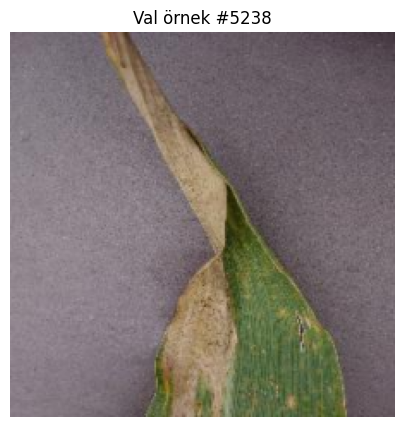

Gerçek (şablon) cümle:
  corn (maize) yaprağında northern leaf blight hastalığının tipik belirtileri görülmektedir.
Modelin ürettiği cümle:
  corn (maize) yaprağında northern leaf blight hastalığının tipik belirtileri görülmektedir.
--------------------------------------------------------------------------------


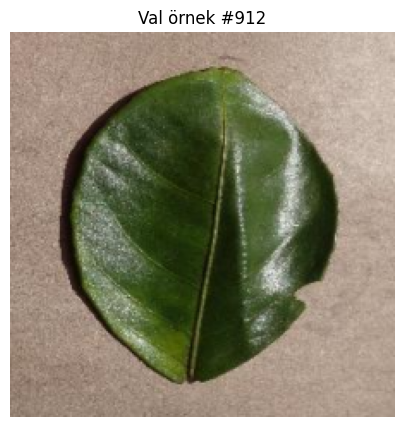

Gerçek (şablon) cümle:
  orange yaprağında haunglongbing (citrus greening) hastalığının tipik belirtileri görülmektedir.
Modelin ürettiği cümle:
  orange yaprağında haunglongbing (citrus greening) hastalığının tipik belirtileri görülmektedir.
--------------------------------------------------------------------------------


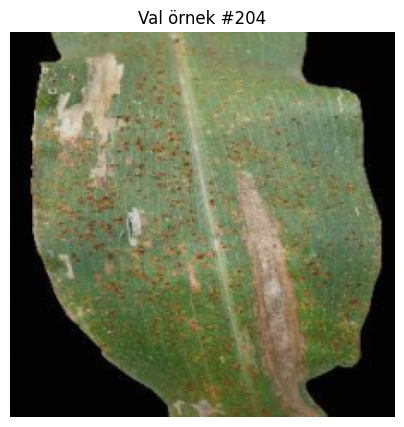

Gerçek (şablon) cümle:
  corn (maize) yaprağında common rust hastalığının tipik belirtileri görülmektedir.
Modelin ürettiği cümle:
  corn (maize) yaprağında common rust hastalığının tipik belirtileri görülmektedir.
--------------------------------------------------------------------------------


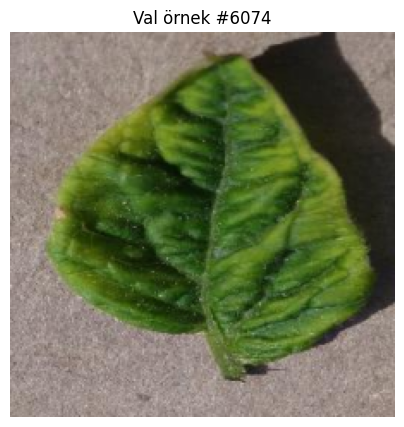

Gerçek (şablon) cümle:
  tomato yaprağında tomato yellow leaf curl virus hastalığının tipik belirtileri görülmektedir.
Modelin ürettiği cümle:
  tomato yaprağında tomato yellow leaf curl virus hastalığının tipik belirtileri görülmektedir.
--------------------------------------------------------------------------------


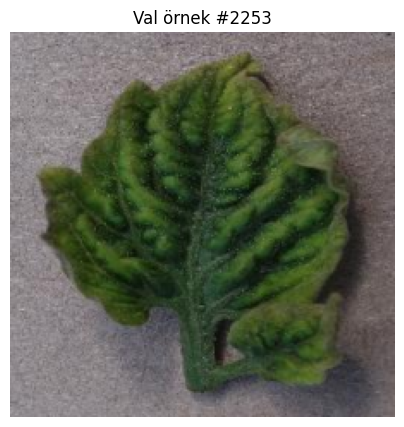

Gerçek (şablon) cümle:
  tomato yaprağında tomato yellow leaf curl virus hastalığının tipik belirtileri görülmektedir.
Modelin ürettiği cümle:
  tomato yaprağında tomato yellow leaf curl virus hastalığının tipik belirtileri görülmektedir.
--------------------------------------------------------------------------------


In [23]:
import matplotlib.pyplot as plt
import random

# Birkaç örnek görüntü seçelim
num_examples = 5

for _ in range(num_examples):
    idx = random.randint(0, len(caption_val_dataset) - 1)
    img_tensor, target_ids = caption_val_dataset[idx]   # transform uygulanmış tensor + hedef text ids

    # Gerçek (şablon) cümle
    target_sentence = decode_ids(target_ids, itos, bos_idx=bos_idx, eos_idx=eos_idx, pad_idx=pad_idx)

    # Model tahmini
    predicted_sentence = generate_caption_from_tensor(
        caption_model,
        img_tensor,
        itos=itos,
        bos_idx=bos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        max_len=30,
        device=device,
    )

    # görüntüyü görselleştirmek için normalizasyonu geri alalım
    img_np = img_tensor.clone().cpu()
    img_np = img_np * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img_np = img_np.clamp(0,1).permute(1,2,0).numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(img_np)
    plt.axis("off")
    plt.title("Val örnek #" + str(idx))
    plt.show()

    print("Gerçek (şablon) cümle:")
    print(" ", target_sentence)
    print("Modelin ürettiği cümle:")
    print(" ", predicted_sentence)
    print("-" * 80)


13. BLEU

In [24]:
!pip install nltk -q
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth = SmoothingFunction().method1

def compute_bleu_on_loader(model, dataset, itos, bos_idx, eos_idx, pad_idx, device):
    model.eval()
    scores = []

    for i in range(len(dataset)):
        img_tensor, target_ids = dataset[i]
        target_sentence = decode_ids(target_ids, itos, bos_idx, eos_idx, pad_idx)

        pred_sentence = generate_caption_from_tensor(
            model,
            img_tensor,
            itos=itos,
            bos_idx=bos_idx,
            eos_idx=eos_idx,
            pad_idx=pad_idx,
            max_len=30,
            device=device,
        )

        # token bazlı BLEU
        ref = target_sentence.split()
        hyp = pred_sentence.split()
        if len(hyp) == 0:
            scores.append(0.0)
        else:
            score = sentence_bleu([ref], hyp, smoothing_function=smooth)
            scores.append(score)

    return sum(scores) / len(scores)

val_bleu = compute_bleu_on_loader(
    caption_model,
    caption_val_dataset,
    itos,
    bos_idx,
    eos_idx,
    pad_idx,
    device
)

print("Val BLEU:", val_bleu)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Val BLEU: 0.9475142550823621


In [25]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clf_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = clf_model.fc.in_features
clf_model.fc = nn.Linear(in_features, num_classes)  # num_classes: PlantVillage sınıf sayısı

clf_model.load_state_dict(torch.load("best_resnet18_plantvillage.pt", map_location=device))
clf_model.to(device)
clf_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

14. GradCAM

In [26]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        def forward_hook(module, inp, out):
            self.activations = out.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.fh = target_layer.register_forward_hook(forward_hook)
        self.bh = target_layer.register_full_backward_hook(backward_hook)

    def __call__(self, x, class_idx=None):
        """
        x: [B,3,H,W] normalize edilmiş tensor
        """
        self.model.zero_grad()
        out = self.model(x)            # [B, num_classes]

        if class_idx is None:
            class_idx = out.argmax(dim=1).item()

        score = out[:, class_idx]
        score.backward()

        grads = self.gradients         # [B,C,H',W']
        acts  = self.activations       # [B,C,H',W']

        weights = grads.mean(dim=(2,3), keepdim=True)   # GAP
        cam = (weights * acts).sum(dim=1, keepdim=True) # [B,1,H',W']
        cam = F.relu(cam)

        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = cam.squeeze().cpu().numpy()

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)
        return cam, class_idx


In [27]:
target_layer = clf_model.layer4[-1]   # son residual block
gradcam = GradCAM(clf_model, target_layer)


In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def denormalize(img_tensor):
    # img_tensor: [3,H,W] (val_test_transform sonrası)
    img = img_tensor.clone().cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) \
              + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0,1).permute(1,2,0).numpy()
    return img

def overlay_cam_on_image(img_tensor, cam):
    """
    img_tensor: [3,H,W] normalize tensor
    cam: [H,W] 0-1 arası
    """
    img = denormalize(img_tensor)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)/255.0
    overlay = 0.4 * heatmap + 0.6 * img
    overlay = np.clip(overlay, 0, 1)
    return img, overlay


15. Test

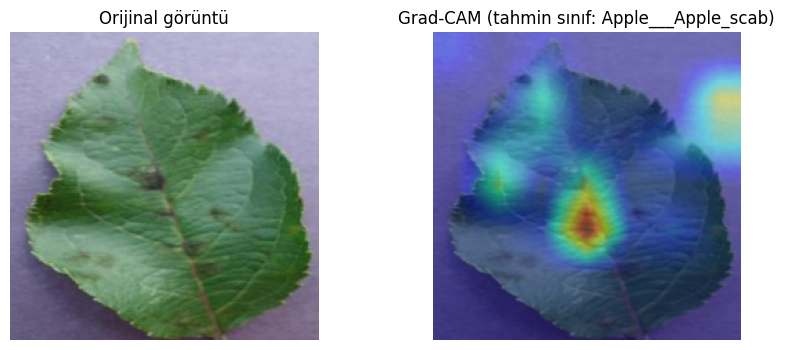

Modelin tahmin ettiği sınıf: Apple___Apple_scab
Modelin ürettiği açıklama:
apple yaprağında apple scab hastalığının tipik belirtileri görülmektedir.


In [29]:
# test_ds: HuggingFace split'in "test" kısmı
idx = 0  # istersen random.randint ile rastgele seç
pil_img = test_ds[idx]["image"]

# sınıflandırma ve Grad-CAM için tensor
img_tensor = val_test_transform(pil_img)   # [3,224,224]
input_batch = img_tensor.unsqueeze(0).to(device)

cam, pred_idx = gradcam(input_batch)
orig, cam_overlay = overlay_cam_on_image(img_tensor, cam)

pred_label = id2label[pred_idx]

# caption tarafı (zaten yazmıştık)
pred_caption = generate_caption_from_tensor(
    caption_model,
    img_tensor,   # [3,H,W] tensor
    itos=itos,
    bos_idx=bos_idx,
    eos_idx=eos_idx,
    pad_idx=pad_idx,
    device=device,
)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.axis("off")
plt.title("Orijinal görüntü")

plt.subplot(1,2,2)
plt.imshow(cam_overlay)
plt.axis("off")
plt.title(f"Grad-CAM (tahmin sınıf: {pred_label})")

plt.show()

print("Modelin tahmin ettiği sınıf:", pred_label)
print("Modelin ürettiği açıklama:")
print(pred_caption)


16. DEMO

In [30]:
!pip install gradio -q
import gradio as gr

In [31]:
def predict_and_explain(pil_image):
    # 1) Tensor'a çevir
    img_tensor = val_test_transform(pil_image)          # [3,H,W]
    input_batch = img_tensor.unsqueeze(0).to(device)

    # 2) Sınıflandırma
    clf_model.eval()
    with torch.no_grad():
        logits = clf_model(input_batch)
        pred_idx = logits.argmax(dim=1).item()

    # ingilizce class adı
    pred_label_en = id2label[pred_idx]
    # arayüzde göstereceğimiz Türkçe class adı
    pred_label_tr = label_tr_map.get(pred_label_en, pred_label_en)

    # 3) caption
    caption = generate_caption_from_tensor(
        caption_model,
        img_tensor,
        itos=itos,
        bos_idx=bos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        device=device,
    )

    # 4) Grad-CAM
    cam, _ = gradcam(input_batch)
    _, cam_overlay = overlay_cam_on_image(img_tensor, cam)
    cam_overlay_uint8 = (cam_overlay * 255).astype("uint8")

    # Gradio'ya Türkçe etiketi döndür
    return pred_label_tr, caption, cam_overlay_uint8


In [32]:
demo = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil", label="Yaprak görüntüsü yükle"),
    outputs=[
        gr.Textbox(label="Tahmin edilen sınıf"),
        gr.Textbox(label="Model açıklaması"),
        gr.Image(label="Grad-CAM ısı haritası"),
    ],
    title="Yaprak Görüntüsünden Bitki Hastalığı Teşhisi",
    description="Bir yaprak fotoğrafı yükleyin: Model hem hastalık sınıfını hem doğal dilde açıklamasını üretir, hem de Grad-CAM ile baktığı bölgeleri gösterir."
)

demo.launch()
# Colab'de tam ekran link için:
# demo.launch(share=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a9ec52d1045083fb2f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
